In [19]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

if "src" in os.getcwd():
    os.chdir("../")

from pathlib import Path

<center><h2>Академия Аналитиков Авито 2024-2025<br><br>Семинар по Audio Processing</h2></center>

<img src="../data/img/pres_outcomes.jpg" width="50%" height="auto">

<span style="font-size: 20px;">*Цель*: познакомиться с инструментами обработки звука. Воспользоваться моделью **Whisper** для решения задачи распознавания речи.</span>

**Преимущества**:

- универсальность -- распознавание на 90+ языков; хорошо обобщается на данные разной природы т.к. видел много разнообразных данных на трейне.
- многозадачность -- помимо задачи ASR умеет распознавать язык, определять границы речевых сегментов, переводить на английский.
- для достойного качества не **нужно больших объемов данных** для дообучения.
- честно говоря, Whisper и так предлагает отличное качество out-of-the-box.
- и [прочие](https://github.com/openai/whisper/discussions/963) [уникальные](https://github.com/openai/whisper/discussions/1174) [способности](https://github.com/openai/whisper/discussions/318).


### Содержание
1. Как работать с аудио
2. Как извлечь признаки
3. Как накладывать аугментации
4. Как запустить дообучение модели
5. Выводы
6. Домашнее задание

### **Часть 1. Как работать с аудио?**

Узнаем, как познакомиться с изучаемым звуком, на что влияет частота дискретизации и как именно мы извлекаем признаки для дальнейшего анализа.

В коде ниже проводится подготовка к разделу.

In [20]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [21]:
def visualize_audio(audio_path: Path):
    wav, sr = torchaudio.load(audio_path, normalize=True)

    print(f"Sample rate: {sr}")
    print(f"Num samples: {wav.shape[-1]}")
    print(f"Duration: {round(wav.shape[-1] / sr, 3)}")

    plt.figure(figsize=(12, 4))
    for channel in range(wav.shape[0]):
        plt.plot(wav[channel], alpha=0.7, label=f"channel {channel}")
    plt.grid()
    plt.xlabel("Time, samples", size=10)
    plt.ylabel("Amplitude, ", size=10)
    plt.legend()
    plt.show()
    display(Audio(data=wav, rate=sr))

#### 🎧 Чтение аудио

При чтении аудио-файла любой доступный фреймворк вернёт вам два значения: сами акустические данные и значение частоты сэмплирования. Это минимум, необходимый для описания одного файла.

**Частота сэмплирования** показывает, сколько значений звукового сигнала (сэмплов) содержится в одной секунде оригинального звука.<br>Иными словами -- это показатель, который помогает нам отобразить порядковые индексы сэмплов на оригинальную ось времени.

Вот, как мы читаем звук с помощью `torchaudio`.

In [22]:
AUDIO_DIR = Path("./data/audio")

# wav -- torch.Tensor из акустических сэмплов; sr -- sample rate, частота сэмплирования
wav, sr = torchaudio.load(AUDIO_DIR / "example_mono_123_hello.wav", normalize=True)

wav.shape, sr

(torch.Size([1, 111014]), 44100)

#### 🦻🦻 Канальность

Из вывода от предыдущей ячейки мы видим, что в тензоре, хранящем акустические сэмплы, есть две оси: **ось каналов** и **ось сэмплов (времени)** соответственно.

Сейчас в оси каналов стоит число 1 -- это из-за того, что аудио у нас записано в формате моно.

В природе встречается три типа аудио-файлов (по числу каналов): 
1. Моноканальные (ch=1) -- такие записи скорее всего записывали на единственный микрофон, из-за чего в файле содержится всего одна акустическая дорожка.
2. Стереоканальные (ch=2) -- в зависимости от применения, в разные каналы кладётся разный звук (в музыклаьной звукозаписи -- для создания объемного звучания, в телефонии контактных центров -- для разделения звонящего и абонента)
3. Многоканальные (ch>2) -- самый редкий зверь. Встречается в конкретных узких областях (кино, домашние кинотеатры, видеоигры).

Давайте визуализируем наше моноканальное аудио:

Sample rate: 44100
Num samples: 111014
Duration: 2.517


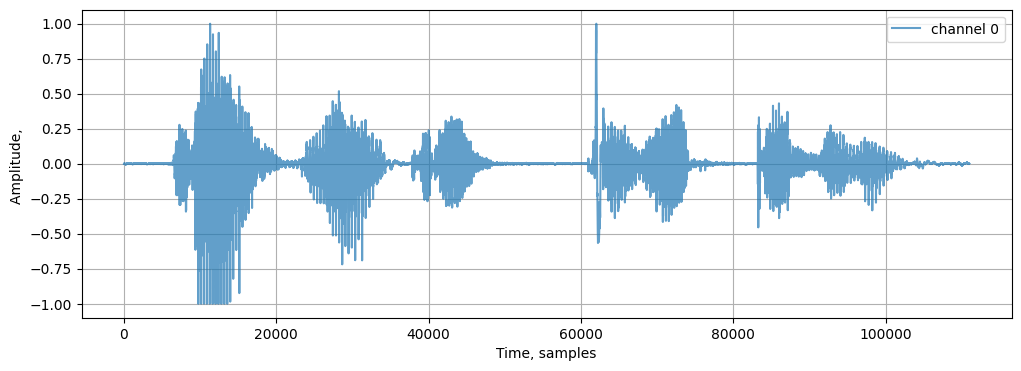

In [23]:
visualize_audio(AUDIO_DIR / "example_mono_123_hello.wav")

А вот, как выглядит звук в формате стерео:

Sample rate: 22050
Num samples: 201066
Duration: 9.119


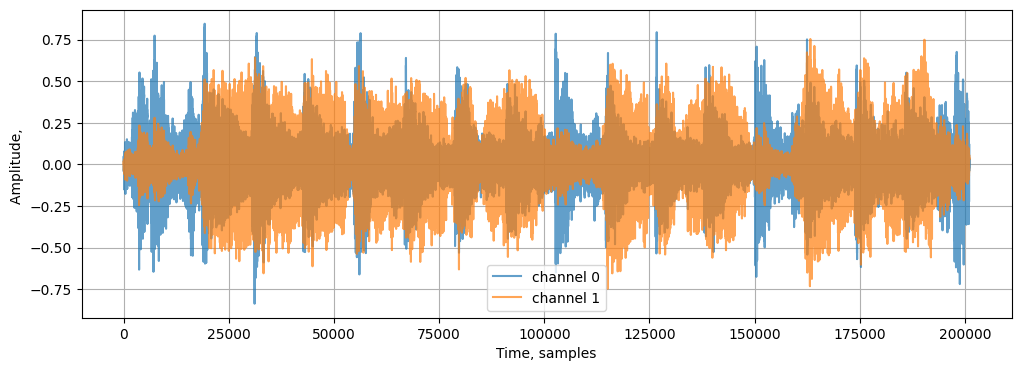

In [24]:
visualize_audio(AUDIO_DIR / "example_stereo_yellow_submarine.wav")

Тут мы видим два сигнала. Давайте послушаем каждый в отдельности.

In [25]:
wav_stereo, sr_stereo = torchaudio.load(AUDIO_DIR / "example_stereo_yellow_submarine.wav", normalize=True)

display(Audio(data=wav_stereo[0].unsqueeze(0), rate=sr_stereo))  # первый канал
display(Audio(data=wav_stereo[1].unsqueeze(0), rate=sr_stereo))  # второй канал

#### А если я не хочу писать код?

```shell
apt-get update
apt-get install mediainfo
mediainfo ./data/audio/example_mono_123_hello.wav
```

#### 🔀 Ресэмплинг

Оказывается, что частоту сэмплирования одного и того же аудио можно менять по своему желанию. Процедура, которая позволяет это сделать называется **ресэмплингом** (resampling).

Ресэмплинг можно провести в две стороны. Если вкратце, то вот, что происходит под капотом:
1. В меньшую сторону (downsampling) -- фильтруем высокие частоты и производим "прореживание" (децимацию) сигнала.
2. В большую сторону (upsampling) -- интерполируем сигнал.

Далее произведем ресэмплинг аудио 44.1 кГц в 16 кГц:

In [ ]:
resampler_44k_to_16k = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
wav_16k = resampler_44k_to_16k(wav)
sr_16k = 16000

print(wav_16k.shape)
display(Audio(data=wav_16k, rate=16000))

Уйдем ещё ниже:

In [ ]:
resampler_44k_to_8k = torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)
wav_8k = resampler_44k_to_8k(wav)

print(wav_8k.shape)
display(Audio(data=wav_8k, rate=8000))

А теперь попробуем восстановить:

In [ ]:
resampler_8k_to_44k = torchaudio.transforms.Resample(orig_freq=8000, new_freq=sr)
wav_44k_recovered = resampler_8k_to_44k(wav_8k)

print(wav_44k_recovered.shape)
display(Audio(data=wav_44k_recovered, rate=44100))

#### <span style="color: #cc6104;">Полезно: Какую частоту сэмплирования выбрать при оцифровке звука?</span>

В области цифровой обработки сигналов существует фундаментальное утверждение:
> Если найти максимальную частоту $f_{max}$ сигнала и умножить на 2, то полученное значение будет минимальной частотой сэмплирования, с которой необходимо оцифровать сигнал, если мы потом захотим восстановить его без потерь.

Утверждение называется **теоремой Котельникова**, а полученная частота сэмплирования -- это **частота Найквиста**.

*Краевой случай 1.*<br>
Основной тон человеческой речи (самая маленькая частота) колеблется в диапазоне от 80 до 500 Гц. Чтобы его закодировать без потерь нам нужна частота сэмплирования 500 * 2 = 1 кГц.

*Краевой случай 2.*<br>
Человеческое ухо воспринимает частоты в диапазоне от 20 до 20000 Гц. Чтобы без потерь оцифровать соответствующий сигнал нам необходима частота сэмплирования 20000 * 2 = 40 кГц.

Как было описано ранее, при даунсэмплинге -- ценой уменьшения объема данных -- мы теряем информацию о высоких частотах.<br>Для задач анализа это не должно быть камнем преткновения -- даже на 8кГц речь весьма членораздельна. Поэтому тут часто можно встретить такие частоты, как 8 и 16 кГц.<br>С другой стороны для задач синтеза высокая частота сэмплирования становится важным критерием т.к. получаемый звук зачастую не должен содержать в себе артефактов. Из-за чего использование звука в 22.05 или 44.1 кГц будет предпочтительнее в этой области.

### **Часть 2. Как извлечь признаки?**

В лекции было рассказано, что использование сырого сигнала для нейронных моделей было бы кощунственно с точки зрения расходов по памяти.<br>По этой причине были введены понятия **кратковременного преобразования Фурье** и последующее извлечение **mel-спектра**.

Далее мы рассмотрим их извлечение на 16 кГц сигнале с помощью `torchaudio`.

In [ ]:
def plot_waveform_and_spec(wav: torch.Tensor, spec: torch.Tensor, spec_title: str):
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(wav[0], alpha=0.7)
    axes[0].set_title("WaveForm сигнала")
    axes[1].imshow(spec[0], origin="lower", aspect="auto", interpolation="nearest")
    axes[1].set_title(spec_title)
    fig.tight_layout()

#### ⚡️ STFT

Напишем код того, как мы извлекаем спектрограмму (матрицу STFT).

In [ ]:
stft_extractor = torch.nn.Sequential(
    torchaudio.transforms.Spectrogram(
        n_fft=1024,
        hop_length=int(sr_16k * 0.01)
    ),
    torchaudio.transforms.AmplitudeToDB()
)
stft = stft_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, stft, "Спектрограмма сигнала")

#### 🎹 Mel-spectrogram

Теперь извлечем мел-спектрограмму.

In [ ]:
mel_extractor = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        n_mels=64,
        n_fft=1024, 
        hop_length=int(sr_16k * 0.01),
    ),
    torchaudio.transforms.AmplitudeToDB()
)
mels = mel_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, mels, "Мел-спектрограмма сигнала")

#### <span style="color: #cc6104;">Полезно: извлекаем более компактные признаки -- MFCC</span>

Мел-спектр -- это не предел возможностей оптимизации признаков для дальнейшего анализа нейросетью.<br>Внимательный зритель заметил, что на мел-спектре есть сильно скореллированные компоненты. Речь идёт о горизонтальных спектральных полосах в моменты времени, когда в звукоизвлечением занимались голосовые связки. Это те самые форманты, о которых говорилось в лекции.<br>*Можно ли их как-то "схлопнуть"?*

Да, можно.<br>При помощи извлечения мел-частотных кепстральных коэффициентов (mel-frequency cepstral coefficients, MFCC).

С точки зрения алгоритма, для перехода `MelSpec -> MFCCs` нам нужно сделать лишь две вещи:
1. Дополнительно "сжать" спектр с помощью [дискретного косинусного преобразования](https://en.wikipedia.org/wiki/Discrete_cosine_transform).
2. Из полученного результата взять только первые `n` компонент.

Мы не пойдём сложным путём изучения формул, а просто применим пару функций `torchaudio`:

In [ ]:
mfcc_extractor = torchaudio.transforms.MFCC(n_mfcc=23)
mfccs = mfcc_extractor(wav_16k)

plot_waveform_and_spec(wav_16k, mfccs, "MFCC-коэффициенты сигнала")

Полученный сигнал небогат, но подойдёт для таких задач, как детекция речевой активности (Voice Activity Detection, VAD)

### **Часть 3. Как накладывать аугментации?**

На практике любой речевой сигнал "загрязнён". Его качество зависит от множества факторов, в т.ч. описываемыми условиями окружающей среды, каналами связи и передачи данных.
Чтобы приблизить сигнал к тому, как он может звучать в реальности, применяют техники искусственного увеличения данных.

В этом разделе мы просмотрим, как именно мы можем исказить данные с помощью простых аугментаций. Разберём наложение фоновых шумов, речи, ревербераций.

<span style="color: #cc6104;">Важно</span><br>
Использование аугментаций -- это оправданная деятельность в тех ситуациях, когда у вас на руках нет огромных наборов *реальных* данных (как, например, 680к часов при пре-трейне Whisper).<br>Аугментации помогают "раздуть" ваши данные, но чрезмерное их использование иногда приводит к тому, что вы чересчур отдаляетесь от вашего конечного распределения (домена). 

Советую чётко выбирать параметры и порядок наложения тех или иных аугментаций.<br>Это касается не только звука.


#### 🎲 Наложение случайного шума

Наложение любого сигнала "поверх" изучаемого является аддитивной процедурой. Иными словами, для создания смеси звучания двух сигналов достаточно их поэлементно сложить.

Проиллюстрируем это на примере наложения сигнала шума Гаусса.

In [ ]:
def apply_gauss_noise(wav: torch.Tensor, noise_amplitude: float = 0.01) -> torch.Tensor:
    # Генерируем белый шум и накладываем на сигнал
    noise = torch.randn_like(wav_16k)
    wav_noised = wav + noise_amplitude * noise

    return wav_noised

In [ ]:
# Применяем функцию 
wav_16k_noised = apply_gauss_noise(wav_16k)

# Извлекаем мел-спектр (для пущей иллюстративности)
mel_noised = mel_extractor(wav_16k_noised)

# Выводим результаты
display(Audio(data=wav_16k_noised, rate=16000))
plot_waveform_and_spec(wav_16k_noised, mel_noised, "Мел-спектрограмма сигнала")

#### 🖼 Наложение фонового шума

А что если случайный шум -- это слишком простой сигнал, и мы хотим, чтобы наша модель умела работать в условиях реального мира, где на фоне речевого сигнала слышны крики детей и лай собак?<br>
Не беда: мы можем произвести наложение одного звука на другой в абсолютно той же манере, как мы это сделали с шумом Гаусса.

Стоит понимать, что реальный шум можно наложить разными способами. В том числе шум может быть наложен, как
1. *фоновый* (пример -- шум толпы) -- тогда он будет звучать на протяжении всей аудиозаписи. Если файл шума длиннее файла сигнала -- значит придётся что-то укорачивать.
2. *однократный* (пример -- хлопок в ладоши) -- тогда мы выбираем случайное место на аудио и добавляем туда шум.

Ниже мы проиллюстрируем наложение фонового шума.

In [ ]:
def apply_background_noise(wav: torch.Tensor, noise_wav: torch.Tensor, noise_ampl_factor: float = 1.0) -> torch.Tensor:
    output = None

    if wav.shape[-1] > noise_wav.shape[-1]:
        # Замощаем шум
        ...
    else:
        # Обрезаем шум
        ...

    output = wav + noise_ampl_factor * noise_wav

    return output

In [ ]:
# Читаем шум
bg_noise, bg_noise_sr = torchaudio.load(AUDIO_DIR / "noise_background_bubble.wav")

# Накладываем его
wav_16k_bg_noised = apply_background_noise(wav_16k, bg_noise, 0.7)

# Смотрим результат
display(Audio(data=wav_16k_bg_noised, rate=sr_16k))
mel_bg_noise = mel_extractor(wav_16k_bg_noised)
plot_waveform_and_spec(wav_16k_bg_noised, mel_bg_noise, "Мел-спектрограмма сигнала (с фоновым шумом)")

#### ↩️ Наложение ревербераций

Реверберации -- это множественное переотражение сигнала от окружающего пространства. Если закрыть глаза и издать громкий звук в пустой комнате / концертном зале / каменной пещере -- мы получим представление о том, в каком помещении находимся из-за характерного множественного эха, отражаемого от стен.

Отсюда следует, что у окружающего нас пространства имеется некоторый "акустический слепок", который называется **импульсной характеристики помещения (Room Impulce Responce, RIR)**.<br>
Мы можем даже записать RIR -- достаточно зайти в необходимое помещение и издать однократный громкий звук (хлопок воздушного шарика, щелчок пальцев)

Пользуясь записанным RIR-ом, появляется возможность промоделировать "звучание" сигнала в том самом помещении при помощи классической операции [свёртки](https://en.wikipedia.org/wiki/Convolution) (<span style="color: gray;">похоже на 1d_conv из pytorch, но ядро отзеркалено по временнОй оси</span>)

In [ ]:
def apply_rir(wav: torch.Tensor, rir: torch.Tensor) -> torch.Tensor:
    # ВременнАя ось всегда самая последняя. Развернем импульсную характеристику
    kernel = rir.flip(dims=[-1])

    # Применим операцию свёртки
    output = torch.nn.functional.conv1d(
        input=wav.unsqueeze(0), 
        weight=kernel.unsqueeze(0), 
        padding=kernel.shape[-1] - 1
    )

    return output.squeeze(0)

In [ ]:
# Прочтем импульсную характеристику, оставим только первую секунду и первый канал
rir, rir_sr = torchaudio.load(AUDIO_DIR / "rir_stairway.wav")
rir = rir[0, 0 : int(rir_sr * 1.0)].unsqueeze(0)
print(rir.shape, rir_sr)

# Посмотрим на нее
rir_stft = stft_extractor(rir)
display(Audio(data=rir, rate=rir_sr))
plot_waveform_and_spec(rir, rir_stft, "Cпектрограмма импульсной характеристики")

In [ ]:
# Применим RIR к сигналу
wav_16k_reverb = apply_rir(wav_16k, rir)
display(Audio(data=wav_16k_reverb, rate=16000))

# Рисуем полученный сигнал и его спектр
mel_reverb = mel_extractor(wav_16k_reverb)
plot_waveform_and_spec(wav_16k_reverb, mel_reverb, "Мел-спектрограмма сигнала (с ревереберацией)")

#### 🧑‍💻️ Чем пользуемся на практике?

Очевидно, самописные аугментации -- дело неоптимальное. Поэтому на практике используются модули, в которые добрые люди заботливо сложили все часто используемые аугментации.

Вот, что нам предлагает модуль `audiomentations`:

```shell

    AddBackgroundNoise
    AddColorNoise
    AddGaussianNoise
    AddGaussianSNR
    AddShortNoises
    AdjustDuration
    AirAbsorption
    Aliasing
    ApplyImpulseResponse
    BitCrush
    BandPassFilter
    BandStopFilter
    Clip
    ClippingDistortion
    Gain
    GainTransition
    HighPassFilter
    HighShelfFilter
    Lambda
    Limiter
    LoudnessNormalization
    LowPassFilter
    LowShelfFilter
    Mp3Compression
    Normalize
    Padding
    PeakingFilter
    PitchShift
    PolarityInversion
    RepeatPart
    Resample
    Reverse
    RoomSimulator
    SevenBandParametricEQ
    Shift
    TanhDistortion
    TimeMask
    TimeStretch
    Trim
```

Давайте применим все наши имплементированные аугментации с помощью функционала этого модуля.

In [ ]:
from audiomentations import (
    Compose, 
    Lambda,
    AddGaussianNoise,
    AddBackgroundNoise, 
    ApplyImpulseResponse,
)

augs = Compose([
    # Налкдаываем шум Гаусса
    AddGaussianNoise(min_amplitude=0.02, max_amplitude=0.03, p=1.0),
    
    # Это фикс -- следующий AddBackgroundNoise не работает, если в аудио присутствует канальное измерение
    Lambda(lambda x, _: x[0], p=1.0),

    # Накладываем фоновый шум и реверберацию
    AddBackgroundNoise(AUDIO_DIR / "noise_background_bubble.wav", min_snr_db=0.8, max_snr_db=2.0, p=1.0),
    ApplyImpulseResponse(AUDIO_DIR / "rir_stairway.wav", p=1.0)
])
wav_16k_augmented = augs(wav_16k.numpy(), sr_16k)

display(Audio(wav_16k_augmented, rate=sr_16k))

### **Часть 4. Как запустить дообучение модели?**

В этом разделе мы применим всё описанное выше и дообучим модель Whisper на работу в сложных условиях окружающей среды. Делать мы это будем на датасете LibriSpeech (подмножество 100 часов обучащих данных).

LibriSpeech -- это сравнительно обширный набор данных, содержащий в себе чтение различных текстов различными дикторами. Каждое аудио в наборе представляет собой одну реплику (сегмент речи). Аудио хранятся в формате `.flac` (free loseless audio codec, сжатие без потерь).

"Сложные условия окружающей среды" я смоделировал с помощью тестовых данных (test-clean) из того же LibriSpeech.

В коде ниже проводится подготовка к разделу.

In [27]:
from typing import Dict, List, Union, Any
from dataclasses import dataclass

import pandas as pd
from tqdm.auto import tqdm
from audiomentations import Gain, AddColorNoise, BitCrush, OneOf

from datasets import DatasetDict, Dataset
from datasets import Audio as DatasetsAudio
from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import evaluate


# Константы данных
DATASETS_DIR = Path("./data/datasets")
INPUT_TRAIN_DATASET_DIR = DATASETS_DIR / "LibriSpeech" / "train-clean-100"
AUGMENTED_TRAIN_DATASET_DIR = DATASETS_DIR / "LS-train-clean-augmented"
AUGMENTED_TRAIN_DATASET_DIR.mkdir(parents=True, exist_ok=True)
TEST_DATASET_DIR = DATASETS_DIR / "LS-test-clean-augmented"

# Модельные константы
MODEL_NAME = "openai/whisper-small"


# Утилиты
def pure_filename(file_path: Path) -> str:
    return ".".join(file_path.name.split(".")[:-1])

#### 💾 Выкачка данных

Первым делом скачаем необходимые наборы данных. А именно:
1. LibriSpeech-train-clean-100hrs
2. Датасет RIR-ов и фоновых шумов

Тестовое множество LibriSpeech качать для оверфиттинга не будем, так как живём по правде.

In [ ]:
# # Качаем и извлекаем ls-train-100hrs
!curl -L -o "./data/datasets/ls_100hrs_train.tar.gz" "https://www.openslr.org/resources/12/train-clean-100.tar.gz"
!tar -xzvf "./data/datasets/ls_100hrs_train.tar.gz" -C "./data/datasets"

In [ ]:
# # Качаем и извлекаем базу шумов и импульсных характеристик
!curl -L -o "./data/datasets/rirs_and_noises.zip" "https://www.openslr.org/resources/28/rirs_noises.zip"
!unzip "./data/datasets/rirs_and_noises.zip" -d "./data/datasets"

Теперь структура директорий выглядит так:

```shell
./data/datasets/LibriSpeech/
    train-clean-100/
        19/
            198/
                19-198-0000.flac
                19-198-0001.flac
                ...
                19-198.trans.txt
            227/
                19-227-0000.flac
                19-227-0001.flac
                ...
                19-227.trans.txt
        2136/
            ...
        ...
```

Обратим внимание на файлы в формате `.txt` -- в них хранится текстовая разметка для каждого сегмента аудио.<br>
Внутри они выглядят примерно так:
```shell
23-456-000 HELLO EVERYONE NICE TO SEE YOU
23-456-001 TAKE YOUR PLACES
```

Подмечаем в левой колонке айди аудио-файла из базы.

Положим содержимое разметок в один файл для удобства.

In [ ]:
records = []
for markup_path in tqdm(list(INPUT_TRAIN_DATASET_DIR.glob("**/*.txt"))):
    # Читаем файл разметки
    with open(markup_path, "r") as file:
        lines = list(map(str.strip, file.readlines()))

    # Парсим его
    curr_records = [
        {
            "audio_id": line.split()[0], 
            "text": " ".join(line.split()[1:]).lower()
        }
        for line in lines
    ]
    records += curr_records

# Конвертируем в датафрейм и сохраняем
if len(records) > 0:
    df = pd.DataFrame(records)
    df.to_csv(AUGMENTED_TRAIN_DATASET_DIR / "markup.csv", index=False)

    print(df.shape)
    df.head(10)

#### 🫨 Наложение аугментаций

Перед тем, как описывать процесс обучения модели, нам необходимо каким-то образом промоделировать акустическую среду.

Сперва подготовим аугментации:

In [ ]:
# Создаем объект-аугментатор
augs = Compose([
    OneOf([AddGaussianNoise(max_amplitude=0.02), AddColorNoise()], p=0.5),
    Lambda(lambda x, _: x[0], p=1.0),
    AddBackgroundNoise(
        sounds_path=DATASETS_DIR / "RIRS_NOISES" / "pointsource_noises", 
        min_snr_db=2.0, 
        max_snr_db=10.0,
        p=1.0
    ),
    ApplyImpulseResponse(
        ir_path=list((DATASETS_DIR / "RIRS_NOISES" / "simulated_rirs" / "largeroom").glob("**/*.wav")),
        p=1.0
    ),
    Gain(p=1.0),
    BitCrush(p=0.1)
])

Затем аугментируем записи, создав отдельную директорию с новыми данными:

In [ ]:
# Подготавливаем выходные директории
output_audio_dir = AUGMENTED_TRAIN_DATASET_DIR / "audio"
output_audio_dir.mkdir(parents=True, exist_ok=True)

for audio_path in tqdm(list(INPUT_TRAIN_DATASET_DIR.glob("**/*.flac"))):
    # Читаем аудио и накладываем аугментации
    wav, sr = torchaudio.load(audio_path, normalize=True)  # Нормализуем амплитуду сигнала
    wav_augmented = augs(wav.numpy(), sr)
    wav_augmented = torch.from_numpy(wav_augmented).unsqueeze(0)

    # Сохраняем новое аудио
    file_name = pure_filename(audio_path)
    torchaudio.save(output_audio_dir / f"{file_name}.wav", wav_augmented, sr)

#### 🚂 Пишем train

Для проведения дообучения модели Whisper будем пользоваться ресурсами модуля `transformers`.

В блоке кода ниже описываем то, как мы собираем метаданные пар "речь-текст".

In [ ]:
def extract_dataset_dict_from_directory(dataset_dir: Path) -> Dict[str, List[str]]:
    df = pd.read_csv(dataset_dir / "markup.csv")
    output = {"audio": [], "text": []}

    # Проходимся по всем строкам в файле разметки и сохраняем 1 - путь до аудио, 2 - текст из аудио
    for _, row in df.iterrows():
        output["audio"].append(str(dataset_dir / "audio" / f"{row.audio_id}.wav"))
        output["text"].append(row.text)
    
    return output

↓ Затем создаём объект датасета, внутри которого описываем разделение на train и test. Говоря подробнее, мы собираем метаданные для ранее аугментированного train-множества и для такого же аугментированного (за кадром) теста.<br>Облачаем колонку audio в соответствующий класс.

In [ ]:
# Создаём объект датасета
asr_dataset = DatasetDict({
    "train": Dataset.from_dict(extract_dataset_dict_from_directory(AUGMENTED_TRAIN_DATASET_DIR)),
    "test": Dataset.from_dict(extract_dataset_dict_from_directory(TEST_DATASET_DIR)),
}).cast_column("audio", DatasetsAudio())

↓ После этого подготавливаем блоки предобработки поступающих в модель данных. А на вход ей могут поступать лишь аудио и текст. Для них мы создаём:
* `feature_extractor` -- блок извлечения акустических признаков. У Whisper это 64-мерные мел-спектрограммы
* `tokenizer` -- токенизатор текстов языковой модели (transformer-декодера) в составе Whisper.

In [ ]:
# Создаем компоненты модели с целью их применения при подготовке датасета и обучении модели
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language="en", task="transcribe")

↓ Подгружаем саму модель Whisper. Размерная сетка моделей делится на пять вариантов:
- `openai/whisper-tiny` -- самая маленькая модель.
- `openai/whisper-base`
- `openai/whisper-small` -- средняя. Её и возьмем для файнтюнинга.
- `openai/whisper-medium`
- `openai/whisper-large` -- самая большая. Помимо базовой версии этой модели, компания OpenAI выпустила еще три: `openai/whisper-large-v2`, `openai/whisper-large-v3`, `openai/whisper-large-v3-turbo`

Имя модели задается в константе `MODEL_NAME`.

In [ ]:
# Подгружаем саму модель и настраиваем ее
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

↓ Описываем логику извлечения признаков для обучения модели. С сырыми текстами и аудио Whisper все равно не работает. Так давайте же преобразуем их необходимым образом и избавимся от сырых данных.

In [ ]:
# Описываем логику подготовки датасета
def prepare_dataset(batch):
    audio = batch["audio"]
    
    # Извлекаем признаки. У Whisper -- это 64 мел-коэффициента
    batch["input_features"] = feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    
    # Токенизируем
    batch["labels"] = tokenizer(batch["text"]).input_ids
    return batch


# Применяем описанную функцию подготовки к датасету.
# Удаляем колонки audio и text -- они нам больше не понадобятся. 
# Вместо них держим input_features (мел-спектры) и labels (токены текстовок)
vectorized_asr_dataset = asr_dataset.map(
    prepare_dataset,
    remove_columns=asr_dataset["train"].column_names,
)

↓ Следующий нюанс -- специфика объединения в batch.<br>
Чтобы объединить несколько объектов данных в один батч (батч мел-спектров и батч айди токенов) нам **необходимо привести их к одной размерности**.<br>
А у нас проблемы: аудио и тексты для разных реплик в 99% случаев не совпадают по длительности. Иными словами *реплика_1* и *реплика_2* будут произнесены за разное количество времени. Равно как и тексты для этих реплик будут состоять из разного числа токенов.

Отсюда возникает желание каким-то образом разные объекты привести к одной длительности. Делается это довольно просто:
- мел-спектры заполняется тишиной (нулями) справа до максимальной длительности.
- массивы токенов заполняются справа `<PAD>`-токенами.

Опишем структуру, которая выполняет ровно то, что описано выше:

In [ ]:
# Опишем и инициализируем collate-класс (to collate - "сопоставлять")

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    feature_extractor: Any
    tokenizer: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
    

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    decoder_start_token_id=model.config.decoder_start_token_id
)

↓ Дело за малым, нам осталось описать параметры обучения и метрики.

Ниже описываются параметры процесса обучения. Предлагаю их изучить вне занятия.

In [ ]:
# Описываем параметры обучения
training_args = Seq2SeqTrainingArguments(
    # Здесь будут лежать логи и чекпоинты модели, появляющиеся по мере обучения
    output_dir="./finetuning-logs",

    # Аргументы, связанные с процессом оптимизации
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    optim="adamw_torch",
    fp16=True,
    
    # Аргументы, связанные с генерацией транскрипции
    predict_with_generate=True,
    generation_max_length=225,

    # Аргументы, связанные с эвал-шагом
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=300,
    eval_steps=300,

    # Аргументы, связанные с логгированием
    logging_steps=25,
    report_to=["tensorboard"],
    
    # Аргументы, связанные с оценкой метриками и отбором моделей
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

↓ Опишем метрики.

Создаётся функция, которая примет на вход объект предсказания модели, в котором лежат индексы токенов сгенерированного текста. Индексы мы переводим в строки и вычисляем WER между идеальной строкой и предсказанной.

In [ ]:
# Определяем функционал подсчета метрик
metric = evaluate.load("wer")


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    
    # Replace -100 with pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    
    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

↓ Создаём объект-trainer, который избавляет нас от рутины написания тренеровочного цикла моделей (со всеми сопутствующими `optim.zero_grad()`, `loss.backward()` и т.д.)

In [ ]:
# Подготавливаем объект-trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=vectorized_asr_dataset["train"],
    eval_dataset=vectorized_asr_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

🔥 Запускаем обучение.

Метрика WER, рапортуемая в таблице во время обучения расчитывается на тестовом множестве.

In [ ]:
# Запускаем обучение
trainer.train()

<img src="../data/img/train_res.jpg" width="45%" height="auto">

↓ Сохраняем финальные веса модели.

In [ ]:
# Сохраняем модель
model.save_pretrained("./whisper-finetuned")
processor = WhisperProcessor(feature_extractor, tokenizer)
processor.save_pretrained("./whisper-finetuned")

#### 💬 Применяем модель 

Первым делом подгрузим обученную модель

In [ ]:
device = "cuda:0"

model_type = "finetuned"
# model_type = "pretrained"

if model_type == "finetuned":
    model = WhisperForConditionalGeneration.from_pretrained("./whisper-finetuned")
    model.to(device)
    processor = WhisperProcessor.from_pretrained("./whisper-finetuned")

elif model_type == "pretrained":
    # Для сравнения можем применить не дообученную модель
    model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
    model.to(device)
    processor = WhisperProcessor.from_pretrained(MODEL_NAME)

else:
    raise ValueError("You've passed wrong `model_type`.")

Запустим обученную модель на одном аудио

In [ ]:
from jiwer import visualize_alignment, process_words


def postprocess_text(text: str) -> str:
    text = text.lower().strip()
    text = "".join(s for s in text if str(s).isalpha() or s == " ")

    return text


def infer_whisper(wav: torch.Tensor, sample_rate: int, lang: str = "en") -> str:
    # Обрабатываем аудио
    inputs = processor(
        wav.squeeze().numpy(),
        sampling_rate=sample_rate,
        return_tensors="pt",
    )

    # Генерируем транскрипцию
    outputs = model.generate(
        **inputs.to(device),
        language=f"<|{lang}|>"
    )

    hypothesis = processor.batch_decode(outputs, skip_special_tokens=True)[0]

    return hypothesis

In [ ]:
# Читаем аудио
wav, sr = torchaudio.load("./data/audio/672-122797-0021.wav")

display(Audio(data=wav, rate=sr))

# Запускаем модель на аудио
hypothesis = infer_whisper(wav, sr, lang="en")
hypothesis = postprocess_text(hypothesis)

# Обрабатываем референс
reference = "and towards christmas he was one of the first that was cut down"
reference = postprocess_text(reference)

# Выводим разницу текстов
out = process_words(reference, hypothesis)
print(visualize_alignment(out))

### **Выводы**

В рамках семинара рассмотрели:

1. Как читать и работать с аудио.
2. Как извлекать признаки. 
3. Что находится под капотом у парочки аугментаций. Узнали, как использовать реальный инструмент для этого.
4. Написали тренеровочный пайплайн модели Whisper и "смогли" ее дообучить. Узнали про ее особенности.

### **Домашка**

#### 💢 Проблема

Попытки распознать слово "Авито" (написанное кирилицей и в нужном падеже) *обычно* приводят к следующей ситуации:

In [ ]:
# Читаем и выводим аудио
wav, sr = torchaudio.load("./data/audio/hello_avito.wav")
print("sample_rate:", sr)
display(Audio(data=wav, rate=sr))

# Ресэмплим, т.к. Whisper обучен на аудио в 16 кГц
wav = torchaudio.transforms.Resample(sr, 16000)(wav)

# Получаем транскрипцию
transcription = infer_whisper(wav, sample_rate=16000, lang="ru")
postprocess_text(transcription)

Видим неспособность модели выхватить специфический термин.

#### 😼 Что нужно сделать?

<span style="color: #cc6104;">От вас требуется заставить модель `openai/whisper-small` говорить слово "авито" в надлежащей форме (именительный падеж, единственное число).</span>

Можно пользоваться любыми способами, кроме очевидных:
1. Делать постпроцессинг распознанной строки, применяя регулярные выражения (или еще что-нибудь).
2. Накладывать ограничения на логиты во время генерации текста моделью (constrained decoding).

Любое другое соображение предлагаю обсуждать в личных сообщениях со мной, чтобы я давал добро или накладывал на него вето.

В общем случае ваша модель должна сама, "от природы", генерировать правильную форму слова "авито" там, где оно было произнесено.

#### 🧑‍🏫️ Описание прикладной области

Система будет работать с 8 кГц моноканальным аудио русской речи, записанной с микрофона телефона во время диалога. На каждой записи находится только один диктор -- другой собеседник ему не мешает. Диктор находится близко к микрофону, речь разборчива (как в примере выше). Часто диктор идёт по улице, едет в транспорте или сидит где-нибудь в столовой. Для экономии места записи были сконвертированы в mp3-формат.

#### 🤖 Формат решения

Ожидаю архив с двумя вещами:
1. Чекпоинт модели: её веса + конфиги processor-а. В общем случае, это папка, которая создается в процессе или результате обучения модели.
2. Скрипт с функцией `transcribe`, принимающей на вход одну пару "аудио, частота сэмплирования" и возвращающей одну строку -- транскрипцию.

#### 🥇 По какой метрике я буду вести оценку качества?

[Keyword Error Rate (KER)](https://www.isca-archive.org/interspeech_2008/park08b_interspeech.pdf):

$$KER = \frac{N_{miss} + N_{detect}}{L_{ref}}$$

где 
- $F_{miss}$ -- количество ошибочно упущенных ключевых слов; 
- $F_{detect}$ -- количество ошибочно распознанных ключевых слов; 
- $L_{ref}$ -- количество ключевых слов в референсе.

Приведу имплементацию:

In [38]:
import jiwer 

def compute_ker(reference: str, hypothesis: str, keyword: str) -> float:
    reference = reference.lower()
    hypothesis = hypothesis.lower()
    keyword = keyword.lower()

    ref_keywords = [word for word in reference.split() if word == keyword]
    hyp_keywords = [word for word in hypothesis.split() if word == keyword]

    ref_keywords = " ".join(ref_keywords)
    hyp_keywords = " ".join(hyp_keywords)

    wer_transforms = jiwer.transforms.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemovePunctuation(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords()
    ])

    if len(ref_keywords) == 0:
        raise ValueError("There is no keywords in reference.")
    
    ker = jiwer.wer(
        ref_keywords, 
        hyp_keywords, 
        reference_transform=wer_transforms, 
        hypothesis_transform=wer_transforms
    )

    return ker

Тест-кейсы:

In [39]:
compute_ker(
    reference="авито вас приветствует компания авито",
    hypothesis="вас приветствует компания авито",
    keyword="авито"
)

0.5

In [45]:
compute_ker(
    reference="авито вас приветствует компания авито",
    hypothesis="авито вас приветствует компания авито",
    keyword="авито"
)

0.0

In [46]:
compute_ker(
    reference="вас приветствует компания авито",
    hypothesis="модель забыла предсказать ТО САМОЕ слово",
    keyword="авито"
)

1.0

In [42]:
compute_ker(
    reference="вас приветствует компания авито",
    hypothesis="авито авито авито авито авито",
    keyword="авито"
)

4.0

In [43]:
compute_ker(
    reference="вас приветствует компания авитО",
    hypothesis="вас приветствует компания авитА",
    keyword="авито"
)

1.0

In [44]:
compute_ker(
    reference="авито вас авито приветствует компания авито",
    hypothesis="авито вас приветствует компания авито",
    keyword="авито"
)

0.3333333333333333

In [47]:
compute_ker(
    reference="а тут в оригинале у нас не было заветного слова",
    hypothesis="авито вас приветствует компания авито",
    keyword="авито"
)

ValueError: There is no keywords in reference.